# Mask GAN


I'm testing the MaskGAN on a dataset that has been tested extensively already - prostate imaging.

0 - 241: train
242 - 294: val
295 - 347: test

In [10]:
import pandas as pd

import monai
from monai.networks.nets import UNet, Discriminator
from monai.transforms import (
    Compose,
    LoadNiftid,
    ScaleIntensityd,
    NormalizeIntensityd,
    AddChanneld,
    ToTensord,
    RandSpatialCropd,
    RandCropByPosNegLabeld,
    CropForegroundd,
    Identityd,
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

In [11]:
class MaskGAN(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        
        self.generator = UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(64, 128, 258, 512, 1024),
            strides=(2, 2, 2, 2),
            norm=monai.networks.layers.Norm.BATCH,
            dropout=0,
        )
        
        self.discriminator = Discriminator(
            in_shape=self.hparams.patch_size,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            norm=monai.networks.layers.Norm.BATCH,
        )
        
        self.generated_masks = None
        self.sample_masks = []
    
    # Data setup
    def setup(self, stage):
        data_df = pd.read_csv('/data/shared/prostate/yale_prostate/input_lists/MR_yale.csv')
        
        train_imgs = data_df['IMAGE'][0:295].tolist()
        train_masks = data_df['SEGM'][0:295].tolist()
        
        train_dicts = [{'image': image, 'mask': mask} for (image, mask) in zip(train_imgs, train_masks)]
        
        train_dicts, val_dicts = train_test_split(train_dicts, test_size=0.15)
        
        # Basic transforms
        data_keys = ["image", "mask"]
        data_transforms = Compose(
            [
                LoadNiftid(keys=data_keys),
                AddChanneld(keys=data_keys),
                NormalizeIntensityd(keys="image"),
                RandCropByPosNegLabeld(
                    keys=data_keys,
                    label_key="mask",
                    spatial_size=self.hparams.patch_size,
                    num_samples=4,
                    image_key="image"
                ),
            ]
        )
        
        self.train_dataset = monai.data.CacheDataset(
            data=train_dicts,
            transform=Compose(
                [
                    data_transforms,
                    ToTensord(keys=data_keys)
                ]
            ),
            cache_rate=1.0
        )
        
        self.val_dataset = monai.data.CacheDataset(
            data=val_dicts,
            transform=Compose(
                [
                    data_transforms,
                    ToTensord(keys=data_keys)
                ]
            ),
            cache_rate=1.0
        )
        
    def train_dataloader(self):
        return monai.data.DataLoader(
            self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True, num_workers=self.hparams.num_workers
        )

    def val_dataloader(self):
        return monai.data.DataLoader(
            self.val_dataset, batch_size=self.hparams.batch_size, num_workers=self.hparams.num_workers
        )
    
    # Training setup
    def forward(self, image):
        return self.generator(image)
    
    def generator_loss(self, y_hat, y):
        dice_loss = monai.losses.DiceLoss(
            to_onehot_y=True,
            softmax=True
        )
        return dice_loss(y_hat, y)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        inputs, labels = batch['image'], batch['mask']
        batch_size = inputs.size(0)
        # Generator training
        if optimizer_idx == 0:
            self.generated_masks = self(inputs)
            
            # Loss from difference between real and generated masks
            g_loss = self.generator_loss(
                self.generated_masks,
                labels
            )
            
            # Loss from discriminator
            # The generator wants the discriminator to be wrong,
            # so the wrong labels are used
            fake_labels = torch.ones(batch_size, 1).cuda(inputs.device.index)
            d_loss = self.adversarial_loss(
                self.discriminator(self.generated_masks.argmax(1).type(torch.FloatTensor).cuda(inputs.device.index)),
                fake_labels
            )
            
            avg_loss = g_loss + 0.5 * d_loss
            
            self.logger.log_metrics({"g_train/g_loss": g_loss}, self.global_step)
            self.logger.log_metrics({"g_train/d_loss": d_loss}, self.global_step)
            self.logger.log_metrics({"g_train/tot_loss": avg_loss}, self.global_step)
            return {'loss': avg_loss}
            
        # Discriminator trainig
        else:
            # Learning real masks
            real_labels = torch.ones(batch_size, 1).cuda(inputs.device.index)
            real_loss = self.adversarial_loss(
                self.discriminator(labels.squeeze(1).type(torch.FloatTensor).cuda(inputs.device.index)),
                real_labels
            )
            
            # Learning "fake" masks
            fake_labels = torch.zeros(batch_size, 1).cuda(inputs.device.index)
            fake_loss = self.adversarial_loss(
                self.discriminator(self.generated_masks.argmax(1).detach().type(torch.FloatTensor).cuda(inputs.device.index)),
                fake_labels
            )
            
            avg_loss = real_loss + fake_loss
            
            self.logger.log_metrics({"d_train/real_loss": real_loss}, self.global_step)
            self.logger.log_metrics({"d_train/fake_loss": fake_loss}, self.global_step)
            self.logger.log_metrics({"d_train/tot_loss": avg_loss}, self.global_step)
            
            return {'loss': avg_loss}
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr)
        d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [g_optimizer, d_optimizer], []
    
    def validation_step(self, batch, batch_idx):
        inputs, labels = (
            batch["image"],
            batch["mask"],
        )
        outputs = self(inputs)
        
        # Sample masks
        if self.current_epoch != 0:
            middle = int(outputs[0].argmax(0).shape[2] / 2)
            image = outputs[0].argmax(0)[:, :, middle].unsqueeze(0).detach()
            self.sample_masks.append(image)
        
        loss = self.generator_loss(outputs, labels)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        self.logger.log_metrics({"val/loss": avg_loss}, self.current_epoch)
        
        if self.current_epoch != 0:
            grid = torchvision.utils.make_grid(self.sample_masks)
            self.logger.experiment.add_image('sample_masks', grid, self.current_epoch)
            self.sample_masks = []
        
        return {"val_loss": avg_loss}

In [3]:
from argparse import Namespace

args = {
    'name': '7-23-2020_MaskGAN_prostate',
    'batch_size': 4,
    'lr': 0.00001,
    'd_lr': 0.0001,
    'patch_size': [128, 128, 16],
    'num_workers': 6,
}

hparams = Namespace(**args)

In [4]:
model = MaskGAN(hparams)

In [9]:
%reload_ext tensorboard
%tensorboard --logdir models/7-23-2020_MaskGAN_prostate/tb_logs

In [6]:
NAME = 'models/' + hparams.name
logger = pl.loggers.TensorBoardLogger(NAME + "/tb_logs/", name='')

# Callbacks
# early_stopping = pl.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=10
# )

checkpoint_callback = pl.callbacks.ModelCheckpoint(filepath=NAME + '/checkpoints/')


trainer = pl.Trainer(
#     auto_scale_batch_size='power',
    checkpoint_callback=checkpoint_callback,
#     early_stop_callback=early_stopping,
    check_val_every_n_epoch=5,
    gpus=1,
    max_epochs=2000,
    logger=logger,
)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0,1]


250/250 Load and cache transformed data:  [==============================]
45/45 Load and cache transformed data:  [==============================]



  | Name          | Type          | Params
------------------------------------------------
0 | generator     | UNet          | 31 M  
1 | discriminator | Discriminator | 428 K 


/data3/johnkim/environments/env_pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

## Evaluation

In [12]:
import os
import glob
import random
import matplotlib.pyplot as plt

In [13]:
model = MaskGAN.load_from_checkpoint('models/7-23-2020_MaskGAN_prostate/_ckpt_epoch_1964.ckpt')

In [19]:
data_df = pd.read_csv('/data/shared/prostate/yale_prostate/input_lists/MR_yale.csv')
        
test_imgs = data_df['IMAGE'][295:].tolist()
test_masks = data_df['SEGM'][295:].tolist()

test_dicts = [{'image': image, 'mask': mask} for (image, mask) in zip(test_imgs, test_masks)]

# Basic transforms
data_keys = ["image", "mask"]
data_transforms = Compose(
    [
        LoadNiftid(keys=data_keys),
        AddChanneld(keys=data_keys),
        NormalizeIntensityd(keys="image"),
        RandSpatialCropd(
            keys=data_keys,
            roi_size=(128, 128, 16),
            random_size=False
        ),
    ]
)

test_dataset = monai.data.Dataset(
    data=test_dicts,
    transform=Compose(
        [
            data_transforms,
            ToTensord(keys=data_keys)
        ]
    )
)


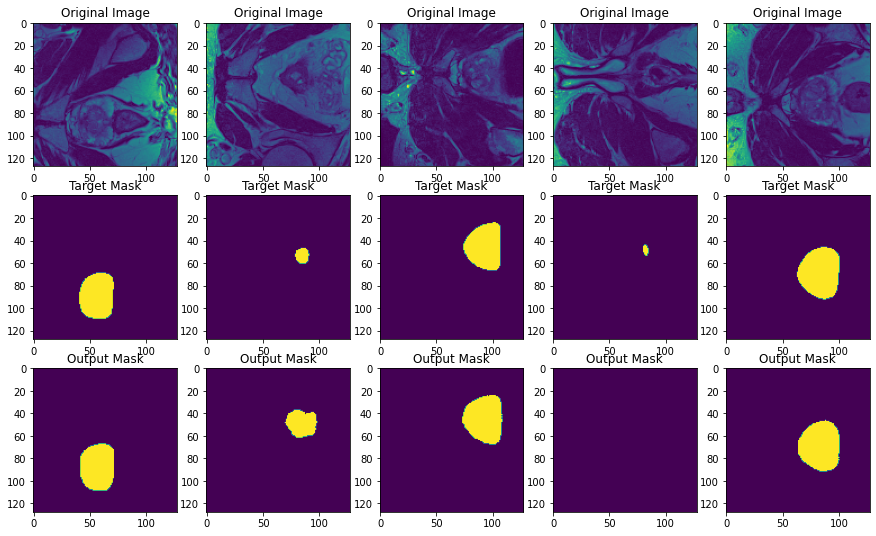

In [22]:
test_samples = random.sample(range(len(test_dataset)), 5)
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
slice_depth = 8
for i in range(5):
    sample = test_dataset[test_samples[i]]
    axs[0, i].imshow(sample['image'][0, :, :, slice_depth])
    axs[0, i].set_title('Original Image')

    axs[1, i].imshow(sample['mask'][0, :, :, slice_depth])
    axs[1, i].set_title('Target Mask')
    
    test_image = sample['image'].unsqueeze(0) #.squeeze(4)
    test_mask = model(test_image)
    test_mask = test_mask.argmax(1).squeeze(0).detach()
    axs[2, i].imshow(test_mask[:, :, slice_depth])
    axs[2, i].set_title('Output Mask')

plt.savefig('results/' + 'MaskGAN' + '.png')